In [ ]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Variational quantum eigensolver

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

This tutorial introduces the fundamental principles of the Variational Quantum Eigensolver (VQE), a cornerstone hybrid quantum-classical algorithm. We will cover the variational principle for finding minimum energy, the construction of Quantum Neural Networks (QNNs) as trial states, the motivation behind VQE's development for near-term quantum devices, and its practical implementation using the QuAIRKit library.

**Table of Contents**

- [Introduction](#introduction)
  - [Background](#background) 
  - [Motivation](#motivation)
- [Variational Quantum Eigensolver](#variational-quantum-eigensolver)
  - [QNN Construction](#qnn-construction)
  - [QuAIRKit Implementation](#quairkit-implementation)
    - [Circuit Construction](#circuit-construction)
    - [Parameters](#parameters)
    - [Training](#training)
      - [Defining the Loss Function](#defining-the-loss-function)
      - [Gradient Calculation and Parameter Updates](#gradient-calculation-and-parameter-updates)
- [Applications in Quantum Chemistry](#applications-in-quantum-chemistry)
  - [Constructing the XXZ model](#constructing-the-xxz-model)
  - [Solve for Ground State Energy](#solve-for-ground-state-energy)
- [Discussion](#discussion)

In [2]:
from typing import List
import numpy as np
import time
import matplotlib.pyplot as plt
import torch

import quairkit as qkit
from quairkit import Circuit, Hamiltonian
from quairkit.database import *
from quairkit.loss import *

In [3]:
# Set plot font
font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

qkit.set_dtype('complex128') # default is 'complex64'
qkit.set_seed(1797587035)  # set a seed for reproducibility

## Introduction

### Background

One of quantum computing's promising near-future applications is solving complex problems in quantum chemistry [1-2]. The **Variational Quantum Eigensolver (VQE)** is a leading algorithm for this purpose, specifically designed for today's Noisy Intermediate-Scale Quantum (NISQ) devices [3-4]. It was originally proposed in 2014, with corresponding authors Alberto Peruzzo, Alán Aspuru-Guzik and Jeremy O'Brien. The algorithm has also found applications in quantum machine learning and has been further substantiated by general hybrid algorithms between quantum and classical computers [5].

The entire method is built upon the **Rayleigh-Ritz variational principle**. This principle states that the calculated energy of any trial quantum state, or *ansatz* $|\Psi(\theta)\rangle$, provides an upper bound for the true ground state energy $E_0$. Therefore, the goal is to find the parameters $\theta$ that minimize this energy:
$$E_0 = \min_{\theta} \langle\Psi(\theta)|\hat{H}|\Psi(\theta)\rangle. \tag{1}$$
Numerically, this is equivalent to finding the smallest eigenvalue $\lambda_{min}$ of the system's Hamiltonian.

<figure style="text-align: center;">
  <img src="figures/vqe_workflow.png" alt="alt text" width="1000"/>
  <figcaption>Figure1. The architecture of a Variational Quantum Eigensolver</figcaption>
</figure>

To achieve this, VQE uses a hybrid quantum-classical loop, as shown in the diagram above. A quantum processor constructs the ansatz using a **Parameterized Quantum Circuit (PQC)** which is a type of Quantum Neural Network (QNN). This circuit typically uses rotation gates as tunable parameters and entangling gates to create complex quantum states. The processor then measures the energy expectation value, $\langle\Psi(\theta)|\hat{H}|\Psi(\theta)\rangle$, and sends this single classical value to a classical optimizer. The optimizer suggests new parameters, and the cycle repeats until the energy converges to a minimum, yielding a robust approximation of the ground state.

### Motivation

The primary motivation for VQE stems from the immense difficulty classical computers face when simulating complex quantum systems. Problems in quantum chemistry, crucial for drug discovery and materials science, require computational resources that grow exponentially with the system's size. By delegating the classically hard task of representing the quantum wave function to a quantum processor, while leaving the optimization to robust classical computers, VQE provides a viable pathway to achieving quantum advantage on near-term hardware. 

This structure of the Parameterized Quantum Circuit (PQC) can be compared to a classical neural network, where the circuit's parameters are trained just like the weights in classical NN to minimize a loss function. This powerful analogy allows the well-developed tools of classical optimization to be applied to solving challenging quantum problems.

## Variational Quantum Eigensolver

### QNN Construction

Quantum Neural Networks are built from fundamental components: qubits, which act as the information carriers, and quantum gates, which perform the operations.

A common QNN is constructed with a layered architecture. Each layer is a sequence of quantum gates composed of two essential parts. First, rotation gates are applied to individual qubits. These gates have tunable parameters (angles) that function as the network's adjustable weights, which are optimized during a training process. Second, entangling gates, such as the CNOT gate, are applied across pairs of qubits. These gates create quantum correlations, enabling the network to represent highly complex states that are impossible for classical computers to simulate efficiently.

A widely used QNN architecture, often called a hardware-efficient ansatz, is built by repeating these layers in sequence. The number of qubits determines the "width" of the network, while the number of repeating blocks defines its "depth".

### QuAIRKit Implementation

#### Circuit Construction

To implement VQE, we firstly need to design a QNN to prepare the wave function ansatz. QuAIRKit has predifined some parameterized circuit templates. Here, we construct a 2-qubit `complex_entangled_layer` with a depth of 5 blocks, where each block contains two single-qubit rotation gates and two CNOT gates.

The quantum circuit for the QNN before training is:


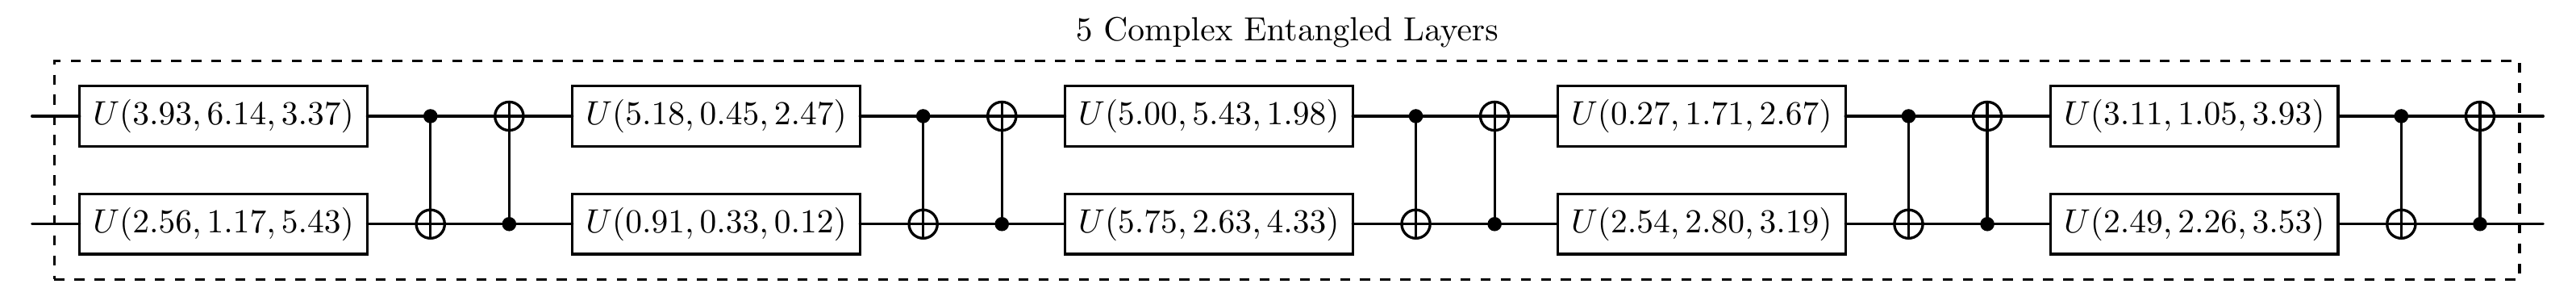

In [4]:
def construct_cir(num_qubits: int, depth: int) -> Circuit:
    r"""Construct the quantum circuit for the variational quantum eigensolver.
    
    Args:
        num_qubits: number of qubits in the quantum circuit.
        depth: number of training layers in the circuit.
    
    Returns:
        the target quantum circuit
    
    """
    circuit = Circuit(num_qubits)

    # add complex entangled layers to the circuit
    circuit.complex_entangled_layer(qubits_idx=list(range(num_qubits)), depth=depth)

    return circuit

num_qubits = 2
depth = 5
circuit = construct_cir(num_qubits, depth)
print("The quantum circuit for the QNN before training is:")
circuit.plot()

You can also manually define a QNN using gates in QuAIRKit, such as `u3`, `rx`, `ry`, `rz`, `cnot`.

The quantum circuit for the QNN constructed by hand is:


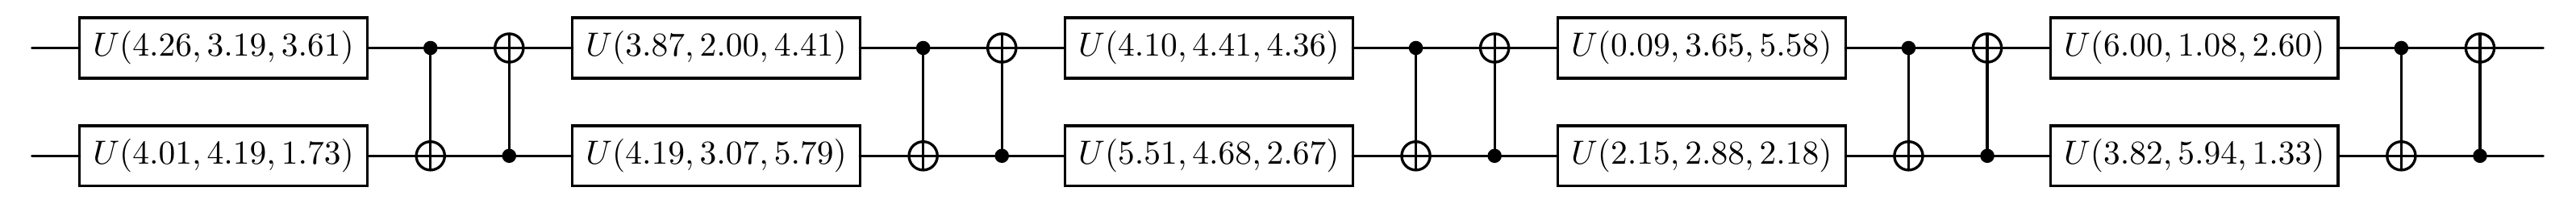

In [5]:
def complex_entangled_layer_by_hand(cir):
    """Add a complex entangled layer to the circuit by hand using u3 and cnot.

    Args:
        cir: the circuit to which the layer will be added.
    """
    param = torch.rand(3, num_qubits) * 2 * torch.pi
    cir.u3(list(range(num_qubits)), param)

    cnot_indices = []
    for i, j in zip(range(num_qubits - 1), range(1, num_qubits)):
        cnot_indices.append((i, j))
        cnot_indices.append((num_qubits - 1, 0))
    cir.cnot(cnot_indices)
    
circuit_by_hand = Circuit(num_qubits)
for _ in range(depth):
    complex_entangled_layer_by_hand(circuit_by_hand)

print("The quantum circuit for the QNN constructed by hand is:")
circuit_by_hand.plot()

#### Parameters

To construct and train a QNN, several key parameters must be defined to guide the optimization process. In addition to the number of qubits and circuit depth we just set, they also include the **number of iterations** (`NUM_ITR`), which determines how many times the optimization loop runs, and the **learning rate** (`LR`), which controls the step size the optimizer takes when updating the circuit's parameters after each step.

While the parameters for the rotation gates of the QNN can be set manually, QuAIRKit can automatically generate initial parameters by drawing random values from a uniform distribution between $0$ and $2π$.

In [6]:
NUM_ITR = 200  # Set the number of optimization iterations
LR = 0.05      # Set the learning rate

#### Training

Training a QNN involves using a classical optimizer to iteratively adjust the circuit's parameters to minimize a defined loss function. This process is managed by a classical computer that orchestrates the quantum computations.

##### Defining the Loss Function

The first step of training is to define a **loss function**, which quantifies the "error" or how far the QNN's output is from the desired goal. For VQE, the objective is to find the lowest possible energy of a given Hamiltonian $H$. Therefore, the most natural loss function is the **expectation value** of that Hamiltonian with respect to the QNN's output state $|\psi(\theta)\rangle$.

$$\text{Loss}(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle, \tag{2}$$

This is implemented by first running the circuit (`cir()`) to produce the output state, and then calculating its expectation value.

In [7]:
def loss_fcn(cir: Circuit, H: Hamiltonian) -> torch.Tensor:
    r"""Compute the loss function of the quantum neural network.
    
    Args:
        cir: the input PQC
        H: the Hamiltonian to be minimized
    
    Returns:
        the loss value

    """
    output = cir()
    exp_val = ExpecVal(H)   # the expectation value operator of the Hamiltonian H
    return exp_val(output)  # calculate the expectation value of the output state

##### Gradient Calculation and Parameter Updates

To minimize the loss function, a classical optimizer needs to calculate the **gradient** of the loss with respect to the circuit's parameters. This gradient indicates the direction of steepest ascent, so the optimizer takes a step in the opposite direction to find a minimum. The core challenge is to efficiently calculate the gradient of a single scalar loss value with respect to potentially hundreds of circuit parameters. This is where the power of PyTorch's [automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) engine becomes essential.

When you call `loss.backward()`, PyTorch initiates a backward traversal of the computational graph. This process is often called the **gradient chain** which is a direct application of the chain rule from calculus to the computational graph of the QNN. The state $|\psi^{(l)}\rangle$ after the $l$-th layer of QNN can be written as:
$$
|\psi^{(l)}\rangle = U_l(\boldsymbol{\theta}^{(l)}) |\psi^{(l-1)}\rangle, \tag{3}
$$
Here, $U_l$ is the quantum operation for the $l$-th layer, parameterized by the vector $\boldsymbol{\theta}^{(l)}$, and $|\psi^{(0)}\rangle$ is the initial state (e.g., $|0...0\rangle$).

The final loss, $L$, is a function of the final state from the last layer, $|\psi^{(N)}\rangle$. To find the gradient of the loss with respect to a single parameter $\theta_j^{(l)}$ in a given layer $l$, the chain rule is applied backward from the final loss, expressed as the product of the derivatives of each subsequent step in the computation:

$$
\frac{\partial L}{\partial \theta_j^{(l)}} = \frac{\partial L}{\partial |\psi^{(N)}\rangle} \cdot \frac{d |\psi^{(N)}\rangle}{d |\psi^{(N-1)}\rangle} \cdot \ldots \cdot \frac{d |\psi^{(l+1)}\rangle}{d |\psi^{(l)}\rangle} \cdot \frac{\partial |\psi^{(l)}\rangle}{\partial \theta_j^{(l)}}, \tag{4}
$$

The final step is to update the parameters. The optimizer looks at the gradient of every parameter and updates the parameter's value according to its specific update rule and the predefined learning rate (LR). For simple gradient descent, the update is 
$$
\theta_j^{(l)} \leftarrow \theta_j^{(l)} - LR* \frac{\partial L}{\partial \theta_j^{(l)}}., \tag{5}
$$
> Optimizers like Adam use more sophisticated rules involving momentum, but the principle of using the gradient to take a step remains the same.

Note that while automatic differentiation works perfectly for quantum circuit simulators, it cannot be directly applied to **actual quantum hardware**, as we cannot peek inside the quantum state during computation. For this, we need a different strategy. The **parameter-shift rule** is a powerful technique to compute analytical gradients on quantum computers.

For many common quantum gates, the derivative of an expectation value $\langle H \rangle$ with respect to $\theta_j$ can be found by running the same circuit twice with shifted parameters:
$$
\frac{\partial \langle H \rangle}{\partial \theta_j} = \frac{1}{2} \left[ \langle H \rangle(\theta_j + \frac{\pi}{2}) - \langle H \rangle(\theta_j - \frac{\pi}{2}) \right]. \tag{6}
$$
The primary trade-off of the method is efficiency: to compute the full gradient for a circuit with $N$ parameters, you must perform $2N$ separate circuit evaluations.

We will use the quantum circuit simulator to complete the gradient calculation, defining the training loop:

In [8]:
def train_model(num_itr: int, LR: float, num_qubits: int, depth: int, H: Hamiltonian) -> None:
    r"""Train the QNN to find the ground-state energy of the Hamiltonian H.
    
    Args:
        num_itr: number of training iterations
        LR: learning rate
        num_qubits: number of qubits in the quantum circuit
        depth: number of training layers in the circuit
        H: the Hamiltonian to be minimized
    """
    cir = construct_cir(num_qubits, depth)

    eigenvalues = torch.linalg.eigvalsh(H.matrix)    # calculate the eigenvalues and eigenvectors of the Hamiltonian
    lambda_0 = torch.min(torch.real(eigenvalues))    # take the minimum eigenvalue as the ground state energy

    loss_list, time_list = [], []

    opt = torch.optim.Adam(lr=LR, params=cir.parameters()) # cir is a Circuit type
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5) # activate scheduler

    for itr in range(num_itr):
        start_time = time.time()
        opt.zero_grad()

        loss = loss_fcn(cir, H) # compute loss

        loss.backward()
        opt.step()

        loss = loss.item()
        scheduler.step(loss) # activate scheduler
        
        loss_list.append(loss)
        time_list.append(time.time() - start_time)

        if itr % (num_itr // 10) == 0 or itr == num_itr - 1:
            print(f"iter: {str(itr).zfill(len(str(num_itr)))}, " +
                f"loss: {loss:.8f}, " +
                f"lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")
            time_list = []

    
    display_results(loss_list, lambda_0, cir)

And then a presentation function.

In [9]:
def display_results(loss_list: List[float], lambda_0: int, circuit: Circuit) -> None:
    r"""Plot the training process and the final circuit.

    Args:
        loss_list: the list of loss values during the training process
        lambda_0: the ground-state energy
        circuit: the final circuit

    """

    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Circuit after training:")

    circuit.plot()  # plot the circuit

    num_itr = len(loss_list)
    base_line = lambda_0 * torch.ones(num_itr)
    list_itr = list(range(num_itr))


    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Training process:")

    plt.plot(
        list_itr,
        loss_list,
        alpha=0.7,
        marker="",
        linestyle="-",
        color="r",
        label=r"$\left\langle {\psi \left( {\theta } \right)} \right|"
        + r"H\left| {\psi \left( {\theta } \right)} \right\rangle $",
    )
    plt.plot(
        list_itr,
        base_line,
        alpha=0.7,
        marker="",
        linestyle=":",
        color="b",
        label="Ground-state energy $\lambda_0$",
    )
    plt.xlabel("Number of iteration")
    plt.ylabel(r"Energy $\lambda_0$")
    plt.legend(loc="best")
    plt.show()

The key is to define the target Hamiltonian. In this example, we will build a simple 2-qubit transverse field Ising model and call the `train_model` function to start training to find its ground state energy.

iter: 000, loss: 0.98380176, lr: 5.00E-02, avg_time: 0.1696s
iter: 020, loss: -2.07092222, lr: 5.00E-02, avg_time: 0.0240s
iter: 040, loss: -2.21777207, lr: 2.50E-02, avg_time: 0.0176s
iter: 060, loss: -2.23504788, lr: 2.50E-02, avg_time: 0.0307s
iter: 080, loss: -2.23578656, lr: 2.50E-02, avg_time: 0.0238s
iter: 100, loss: -2.23603351, lr: 2.50E-02, avg_time: 0.0178s
iter: 120, loss: -2.23606530, lr: 2.50E-02, avg_time: 0.0114s
iter: 140, loss: -2.23606776, lr: 2.50E-02, avg_time: 0.0312s
iter: 160, loss: -2.23606796, lr: 2.50E-02, avg_time: 0.0302s
iter: 180, loss: -2.23606798, lr: 2.50E-02, avg_time: 0.0183s
iter: 199, loss: -2.23606798, lr: 2.50E-02, avg_time: 0.0154s

----------------------------------------------------------------------------------------------------

Circuit after training:


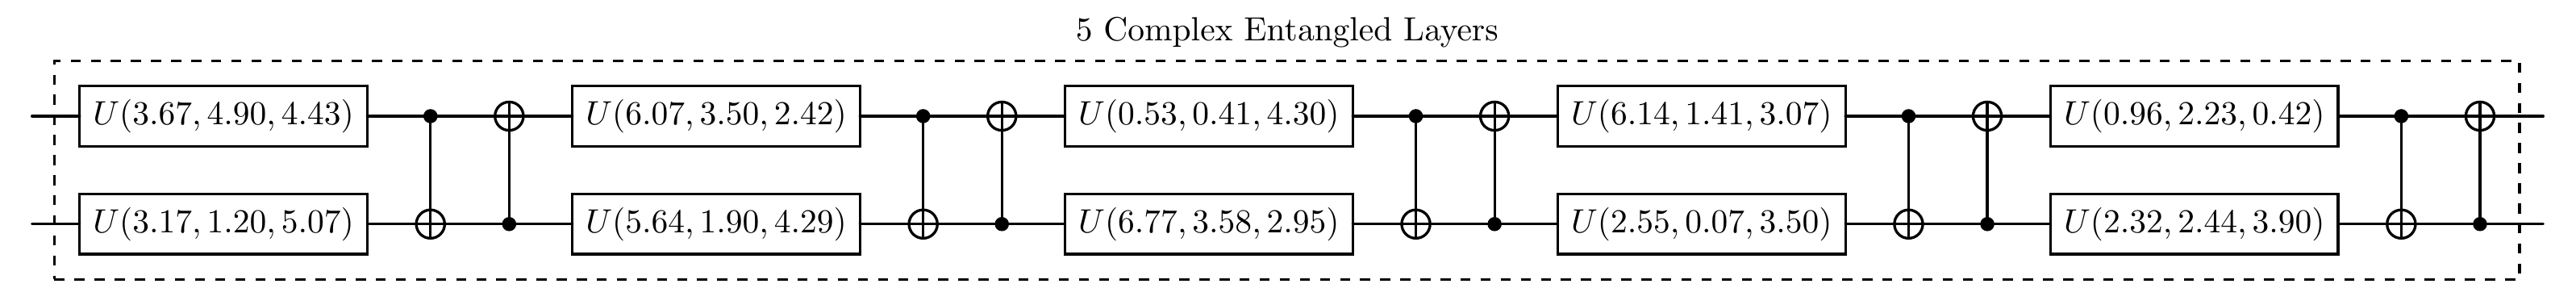


----------------------------------------------------------------------------------------------------

Training process:


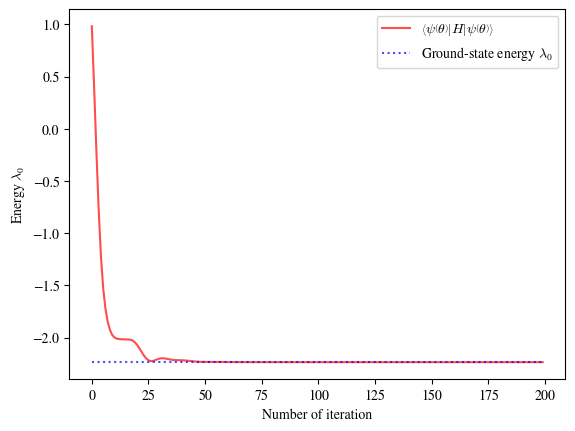

In [10]:
# Define the Hamiltonian for a 2-qubit system, H = -Z_0*Z_1 + X_0 + X_1
edges = -torch.tensor([[0, 1], [1, 0]])  # Ferromagnetic interaction between qubit 0 and 1
vertices = torch.tensor([1, 1])           # Uniform transverse field on both qubits
hamiltonian = ising_hamiltonian(edges, vertices)

train_model(NUM_ITR, LR, num_qubits, depth, hamiltonian)

## Applications in Quantum Chemistry 

Now that we have established the VQE workflow, we can apply it to find the ground state energy of other important physical systems. In this section, we will construct the Hamiltonian for the Heisenberg XXZ model and use the same VQE algorithm to solve for its ground state energy.

### Constructing the XXZ Model

The Heisenberg XXZ model is a fundamental model in quantum mechanics used to describe interacting spin systems, such as those found in magnetic materials. It is a generalization of the Ising model and is defined by the following Hamiltonian:

$$H_{XXZ} = \sum_{\langle i,j \rangle} J \left( X_i X_j + Y_i Y_j + \Delta Z_i Z_j \right), \tag{6}$$

Here, the sum is over neighboring qubits $\langle i,j \rangle$, $J$ is the coupling strength, and $\Delta$ is the anisotropy parameter that controls the relative strength of the $ZZ$ interaction compared to the $XX$ and $YY$ interactions.

In QuAIRKit, we can build this Hamiltonian term by term using the `Hamiltonian` class, which takes a list of Pauli strings and their corresponding coefficients. For a simple 2-qubit system, we can define the model as follows.

In [11]:
# Define model parameters
J = 1.0
Delta = 0.5

# Construct the 2-qubit XXZ Hamiltonian
hamiltonian_list = [
    (J, f"X0 X1"),
    (J, f"Y0 Y1"),
    (J * Delta, f"Z0 Z1")
]
H_xxz = Hamiltonian(hamiltonian_list)

print("XXZ Hamiltonian matrix:\n", H_xxz.matrix)

XXZ Hamiltonian matrix:
 tensor([[ 0.5000+0.j,  1.0000-1.j],
        [ 1.0000+1.j, -0.5000+0.j]])


Before running VQE, we can solve for the ground state energy classically for this small system. This provides a baseline to verify our VQE result.

In [12]:
# Calculate the exact ground state energy using classical linear algebra
eigenvalues = torch.linalg.eigvalsh(H_xxz.matrix)
ground_state_energy = torch.min(torch.real(eigenvalues))

print(f"Exact Ground State Energy: {ground_state_energy.item()}")

Exact Ground State Energy: -1.5


### Solve for Ground State Energy

We will now apply our VQE algorithm to find the ground state energy of the XXZ Hamiltonian constructed above. The procedure is identical to the one used for the Ising model; the only change is the target Hamiltonian that we use to define our loss function. We will use the same QNN architecture, loss function, and training functions as before.

The following code sets up the VQE parameters and runs the training loop, plotting the convergence of the VQE energy against the exact value we just calculated.

iter: 000, loss: 0.46257777, lr: 5.00E-02, avg_time: 0.0459s
iter: 020, loss: -1.48599069, lr: 5.00E-02, avg_time: -0.0004s
iter: 040, loss: -1.49584380, lr: 2.50E-02, avg_time: 0.0139s
iter: 060, loss: -1.49909928, lr: 2.50E-02, avg_time: 0.0179s
iter: 080, loss: -1.49984123, lr: 2.50E-02, avg_time: 0.0239s
iter: 100, loss: -1.49999257, lr: 2.50E-02, avg_time: 0.0113s
iter: 120, loss: -1.49999815, lr: 2.50E-02, avg_time: 0.0109s
iter: 140, loss: -1.49999982, lr: 2.50E-02, avg_time: 0.0153s
iter: 160, loss: -1.49999999, lr: 2.50E-02, avg_time: 0.0198s
iter: 180, loss: -1.50000000, lr: 2.50E-02, avg_time: 0.0230s
iter: 199, loss: -1.50000000, lr: 2.50E-02, avg_time: 0.0198s

----------------------------------------------------------------------------------------------------

Circuit after training:


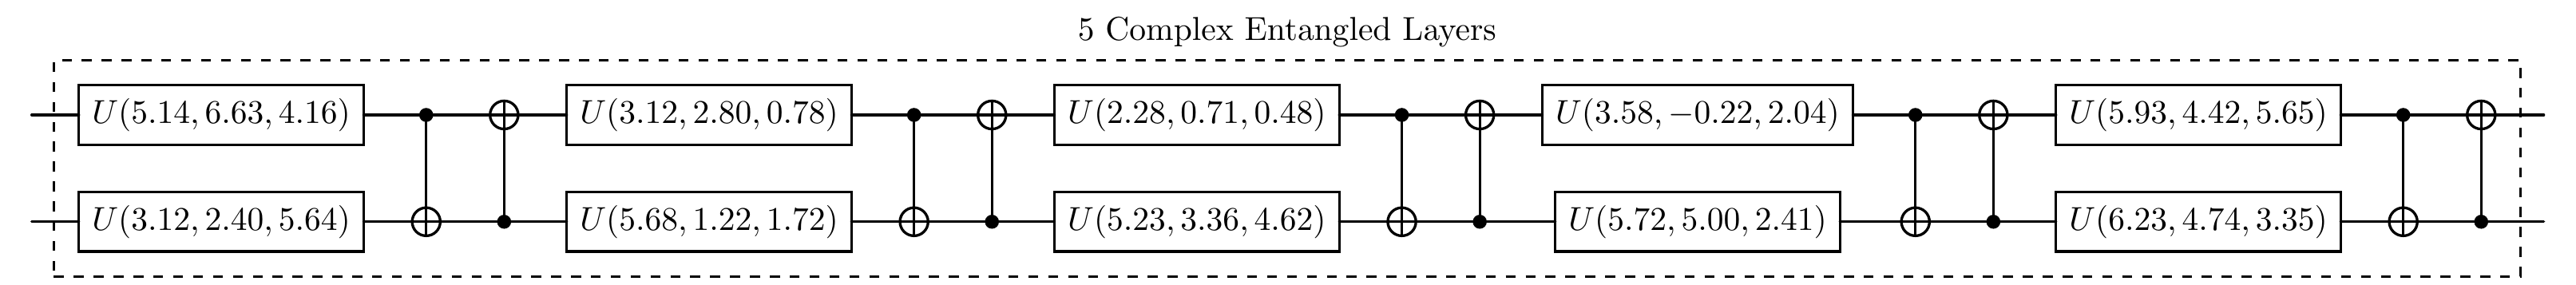


----------------------------------------------------------------------------------------------------

Training process:


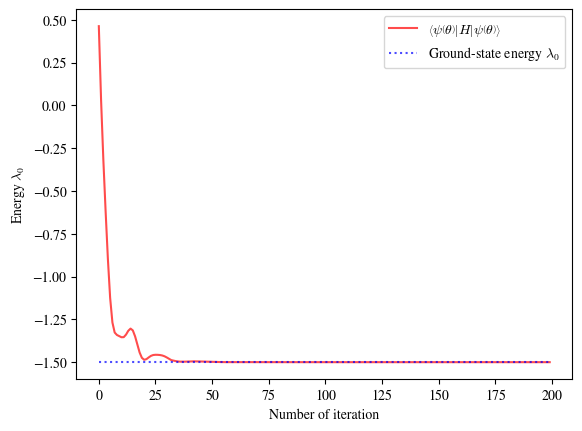

In [13]:
train_model(NUM_ITR, LR, num_qubits, depth, H_xxz)

As the plot shows, the VQE algorithm successfully trains the QNN's parameters, and the calculated energy converges to the exact ground state energy of the XXZ model. This demonstrates the flexibility and power of the VQE approach for solving different problems in quantum physics.

## Discussion

In this tutorial, we have explored the Variational Quantum Eigensolver (VQE) from its theoretical foundations to its practical implementation in QuAIRKit. The hybrid quantum-classical nature of VQE makes it a leading algorithm for near-term quantum computing, offering a robust approach to tackling problems in quantum chemistry and materials science.

A crucial factor for the success of any VQE simulation is the choice of the PQC architecture, or **ansatz**. The effectiveness of an ansatz hinges on a trade-off between **expressibility** and **trainability**. An ansatz must be expressive enough to represent the true ground state of the system, meaning a circuit with deeper layers and more entanglement can better explore the problem's solution space. However, deeper circuits are also more susceptible to noise and can lead to optimization challenges like "barren plateaus," where gradients vanish and training becomes ineffective. Balancing this trade-off remains a key area of research in the development of quantum algorithms.

---

## References

[1] Cao, Yudong, et al. Quantum Chemistry in the Age of Quantum Computing. Chemical reviews 119.19 (2019): 10856-10915.

[2] McArdle, Sam, et al. Quantum computational chemistry. Reviews of Modern Physics 92.1 (2020): 015003.

[3] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 4213.

[4] Moll, Nikolaj, et al. Quantum optimization using variational algorithms on near-term quantum devices. Quantum Science and Technology 3.3 (2018): 030503.

[5] McClean, Jarrod R., et al. "The theory of variational hybrid quantum-classical algorithms." New Journal of Physics 18.2 (2016): 023023.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
| $H$ | $H_{XXZ}$ | Hamiltonian operator or matrix representing the system's energy.|
| $E_0$ | $\lambda_{min}, \lambda_0$ | The ground state energy of the system, which is the minimum eigenvalue of the Hamiltonian.|
| $\ket{\Psi}$ | $\ket{\psi}, \ket{\Psi(\boldsymbol\theta)}, \ket{\Psi_0}, \ket{\psi^{(l)}}$ | A quantum state vector (ket). Often represents the trial wavefunction or an eigenstate.|
| $\braket{O}$ | $\braket{\Psi \| O \| \Psi}$ | The expectation value of an operator $O$ with respect to a quantum state $\ket{\Psi}$.|
| $\boldsymbol{\theta}$ | $\theta_j^{(l)}$ | The set of classical, trainable parameters in a Parameterized Quantum Circuit (PQC).|
| $U$ | $U(\boldsymbol{\theta}), U_l(\boldsymbol{\theta}^{(l)})$ | A unitary quantum operation, representing a quantum gate or the entire circuit.|
| $X, Y, Z$ | $X_i, Y_i, Z_i, \sigma_x, \sigma_y, \sigma_z$ | The Pauli matrices/operators, acting on the $i$-th qubit.|
| $L$ | $L(\theta)$ | The loss function used for optimization, typically the energy expectation value in VQE.|
| $J$ | | The coupling strength parameter in the Heisenberg XXZ model. |
| $\Delta$ | | The anisotropy parameter in the Heisenberg XXZ model. |

In [14]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.2
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
